<div style="color:#3c4d5a; border-top: 7px solid #42A5F5; border-bottom: 7px solid #42A5F5; padding: 5px; text-align: center; text-transform: uppercase"><h1>Multivariate Analysis with Clustering for Alzheimer’s Disease Prediction</h1> </div>

This notebook presents a supervised machine learning approach for Alzheimer’s disease classification. The dataset contains information from 2,149 patients aged between 60 and 90 years, with a total of 35 variables related to clinical and demographic factors. The target variable is Diagnosis, where 0 indicates no Alzheimer’s disease and 1 indicates the presence of Alzheimer’s disease, defining a binary classification task.

The notebook covers data preparation, including exploratory analysis, class frequency evaluation, descriptive statistics, correlation analysis, and feature transformation. Subsequently, KNN, Neural Network, and Gaussian Naive Bayes models are developed, fine-tuned, and evaluated. All experiments are tracked using MLflow, and the models are compared to identify the best-performing approach.

- [Dataset Load](#dataset)
- [Treatment of Variables](#tratamiento-de-variables)
- [PCA](#pca)
- [Determine the centroid](#centroide)
- [Prediction](#pred)
- [Clustering (K-Means) vs Other Models](#comparacion)
- [Conclusion](#conclusion)

## **Imported modules**

---



In [1]:
import kagglehub
import os
from kagglehub import dataset_download
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, precision_score, recall_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

print("Imported modules")

Imported modules


<div id="dataset" style="color:#37475a; border-bottom: 7px solid orange; width: 100%; margin-bottom: 15px; padding-bottom: 2px"><h2>Dataset Load</h2> </div>


<div style="color:#37475a"><h2>Dataset Visualization (Dimensions)</h2> </div>

In [2]:
# ==========================================
# 1. Data Acquisition and Loading
# ==========================================

# Download the specific Alzheimer's dataset from Kaggle using kagglehub.
# This ensures we always have the latest version of the data locally.
path = dataset_download("rabieelkharoua/alzheimers-disease-dataset")

# Verify the local path where the dataset has been saved.
print("Dataset downloaded to:", path)

# Load the dataset into a Pandas DataFrame.
# We append the specific CSV filename to the path returned by the downloader.
data = pd.read_csv(path + "/alzheimers_disease_data.csv")

# ==========================================
# 2. Initial Data Inspection
# ==========================================

# Check the initial size of the dataset (Rows, Columns).
print("Initial Dimensions:", data.shape)

# Display the first 5 rows to visualize the feature columns and data types.
data.head()

Dataset downloaded to: C:\Users\user\.cache\kagglehub\datasets\rabieelkharoua\alzheimers-disease-dataset\versions\1
Initial Dimensions: (2149, 35)


,PatientID,Age,Gender,Ethnicity,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,...,MemoryComplaints,BehavioralProblems,ADL,Confusion,Disorientation,PersonalityChanges,DifficultyCompletingTasks,Forgetfulness,Diagnosis,DoctorInCharge
0,4751,73,0,0,2,22.927749,0,13.297218,6.327112,1.347214,...,0,0,1.725883,0,0,0,1,0,0,XXXConfid
1,4752,89,0,0,0,26.827681,0,4.542524,7.619885,0.518767,...,0,0,2.592424,0,0,0,0,1,0,XXXConfid
2,4753,73,0,3,1,17.795882,0,19.555085,7.844988,1.826335,...,0,0,7.119548,0,1,0,1,0,0,XXXConfid
3,4754,74,1,0,1,33.800817,1,12.209266,8.428001,7.435604,...,0,1,6.481226,0,0,0,0,0,0,XXXConfid
4,4755,89,0,0,0,20.716974,0,18.454356,6.310461,0.795498,...,0,0,0.014691,0,0,1,1,0,0,XXXConfid



<div style="color:#37475a"><h2>Data Cleaning</h2> </div>

In [3]:
#In this case there were no null values, but it fits the procedure of Phase 1, data cleaning
data = data.drop_duplicates()
# Basic filler (adjust if you need a different strategy)
data = data.fillna(method="ffill").fillna(method="bfill")


C:\Users\user\AppData\Local\Temp\ipykernel_9188\3576345437.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method="ffill").fillna(method="bfill")


<div id="tratamiento-de-variables" style="color:#37475a; border-bottom: 7px solid orange; width: 100%; margin-bottom: 15px; padding-bottom: 2px"><h2>Treatment of Variables</h2> </div>

In [4]:
#Variable Elimination
data = data.drop(columns=["PatientID", "DoctorInCharge"]).copy()

#New Variables
data['age_mmse_interaction'] = data['Age'] * data['MMSE']
data['cognitive_decline_score'] = data['MMSE'] + data['FunctionalAssessment'] + data['ADL']
data['vascular_risk_score'] = (
    data['Hypertension'] +
    data['CardiovascularDisease'] +
    data['Diabetes'] +
    data['Smoking']
)
data['cholesterol_ratio'] = data['CholesterolLDL'] / (data['CholesterolHDL'] + 0.01)
data['bp_ratio'] = data['SystolicBP'] / (data['DiastolicBP'] + 0.01)

data['symptom_count'] = (
    data['Confusion'] +
    data['Disorientation'] +
    data['PersonalityChanges'] +
    data['DifficultyCompletingTasks'] +
    data['Forgetfulness'] +
    data['MemoryComplaints'] +
    data['BehavioralProblems']
)

data['lifestyle_score'] = (
    data['PhysicalActivity'] +
    data['DietQuality'] +
    data['SleepQuality']
)

data['age_group'] = pd.cut(data['Age'], bins=[59, 70, 80, 91], labels=[0, 1, 2])

In order to enrich the dataset and capture complex relationships among the original variables, new derived variables were created that may be relevant for predictive modeling:

age_mmse_interaction: interaction between age and the MMSE cognitive score, aimed at capturing how the effect of age may influence cognitive performance.

cognitive_decline_score: sum of MMSE, Functional Assessment, and ADL, representing an overall score of cognitive and functional decline.

vascular_risk_score: combination of hypertension, cardiovascular disease, diabetes, and smoking status, reflecting the patient’s vascular risk.

cholesterol_ratio: ratio between LDL and HDL cholesterol, used as an indicator of lipid-related cardiovascular risk.

bp_ratio: ratio between systolic and diastolic blood pressure, used to assess hemodynamic risk.

symptom_count: sum of symptoms such as confusion, disorientation, personality changes, difficulty performing tasks, forgetfulness, and memory complaints, representing the total burden of cognitive and behavioral symptoms.

lifestyle_score: combination of physical activity, diet quality, and sleep quality, reflecting an indicator of healthy lifestyle habits.

age_group: categorization of age into groups (60–70, 71–80, 81–91) to facilitate segmented analyses by age range.

These derived variables allow for the capture of interactions and complex patterns that may not be evident in individual variables, potentially improving the predictive performance of the models.


<div style="color:#37475a"><h2>Definition of Columns</h2> </div>


In [5]:
# 3. Feature Selection and Grouping

# Define the target variable (dependent variable) for the classification task.
target = "Diagnosis"

# Group 1: Categorical Features
# These variables contain nominal or ordinal data that will require encoding
# (e.g., One-Hot Encoding) to be used in the model.
# Note: 'age_group' is included here as it was created by binning the continuous 'Age' variable.
categoricas = ["Gender", "Ethnicity", "EducationLevel", "age_group"]

# Group 2: Numerical Features
# These are continuous or discrete quantitative variables.
# They typically require scaling (e.g., StandardScaler) to normalize their range.
# This list includes both original features (like 'Age', 'BMI') and
# engineered features (like 'age_mmse_interaction', 'cognitive_decline_score').
numericas = [
    "Age", "BMI", "AlcoholConsumption", "PhysicalActivity",
    "DietQuality", "SleepQuality",
    "SystolicBP", "DiastolicBP", "CholesterolTotal",
    "CholesterolLDL", "CholesterolHDL", "CholesterolTriglycerides",
    "MMSE", "FunctionalAssessment", "ADL",
    "age_mmse_interaction", "cognitive_decline_score", "vascular_risk_score",
    "cholesterol_ratio", "bp_ratio", "symptom_count", "lifestyle_score"
]

# Group 3: Binary Features
# These variables are already in a binary format (0 or 1).
# They generally do not require scaling or encoding and can be passed through as-is.
binarias = [
    "Smoking", "FamilyHistoryAlzheimers", "CardiovascularDisease",
    "Diabetes", "Depression", "HeadInjury", "Hypertension",
    "MemoryComplaints", "BehavioralProblems",
    "Confusion", "Disorientation", "PersonalityChanges",
    "DifficultyCompletingTasks", "Forgetfulness"
]


<div style="color:#37475a"><h2>Split Train</h2> </div>

In [6]:
X = data.drop(columns=[target])
y = data[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

The dataset was split into training and testing sets using train_test_split. Eighty percent of the data was allocated for model training (X_train, y_train), while the remaining 20% was reserved for performance evaluation (X_test, y_test). In addition, the stratify=y parameter was used to ensure that the proportion of patients with and without Alzheimer’s disease remained consistent across both sets, preserving the original distribution of the target variable and preventing bias during model training and evaluation.


<div style="color:#37475a"><h2>Transformer Object</h2> </div>


In [7]:
# 5. Data Preprocessing Pipeline

# Initialize the ColumnTransformer.
# This allows us to apply specific transformations to different columns (Categorical, Numerical, Binary)
# in a single step, ensuring a clean and consistent data flow.
preprocessor = ColumnTransformer(
    transformers=[
        # 1. Categorical Features: Apply One-Hot Encoding.
        # - handle_unknown="ignore": Prevents errors if unknown categories appear in future data.
        # - drop='first': Removes one dummy variable per category to avoid multicollinearity (dummy variable trap).
        ("cat", OneHotEncoder(handle_unknown="ignore", drop='first'), categoricas),

        # 2. Numerical Features: Apply Standard Scaling (Z-score normalization).
        # - Scales data to have Mean = 0 and Variance = 1.
        # - CRITICAL: Essential for PCA and K-Means, as these algorithms are sensitive to the scale of distances.
        ("num", StandardScaler(), numericas),

        # 3. Binary Features: Pass through without changes.
        # - Since they are already 0/1, no scaling or encoding is required.
        ("bin", "passthrough", binarias)
    ],
    # Any columns not listed in the groups above will be dropped from the dataset.
    remainder='drop'
)

# 6. Applying Transformations

# fit_transform on TRAIN:
# 1. Learns the scaling parameters (mean, std) and encoding categories from X_train.
# 2. Transforms X_train.
X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep = preprocessor.transform(X_test)

<div id="pca" style="color:#37475a; border-bottom: 7px solid orange; width: 100%; margin-bottom: 15px; padding-bottom: 2px"><h2>PCA</h2> </div>

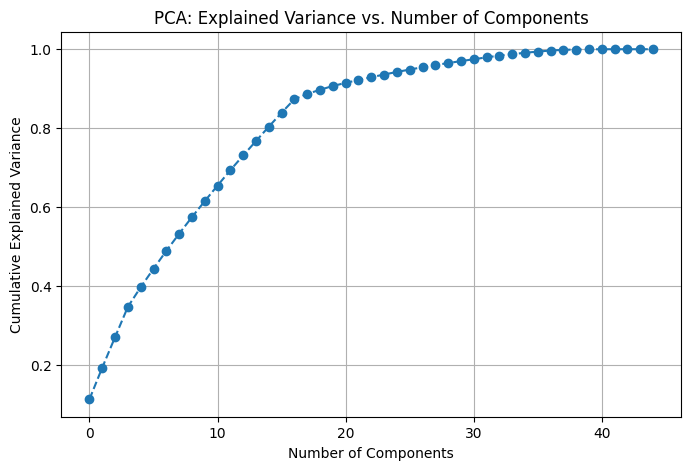

In [8]:
# Initialize PCA without a fixed number of components.
# This keeps all components initially so we can analyze the variance ratio of each.
pca = PCA()

# Fit PCA on the preprocessed training data and transform it.
# This converts the correlated variables into a set of linearly uncorrelated
# principal components.
X_train_pca_full = pca.fit_transform(X_train_prep)

# 8. Variance Analysis (Elbow Method for PCA)

# Calculate the cumulative sum of the explained variance ratio.
# This array tells us how much information (variance) is retained
# if we select 1, 2, 3... up to N components.
var_acumulada = np.cumsum(pca.explained_variance_ratio_)

# Plot the cumulative variance to visually determine the optimal number of components.
plt.figure(figsize=(8, 5))
plt.plot(var_acumulada, marker='o', linestyle='--')

# Labels translated to English for the documentation
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA: Explained Variance vs. Number of Components")
plt.grid(True)
plt.show()

In [9]:
n_componentes = np.argmax(var_acumulada >= 0.85) + 1
print("Optimal number of components:", n_componentes)


Optimal number of components: 17


In [10]:
pca = PCA(n_components=n_componentes)

X_train_pca = pca.fit_transform(X_train_prep)
X_test_pca = pca.transform(X_test_prep)

In [11]:
# 9. Optimal K Discovery (Elbow Method)
def descubrirK(X, k_max=10):
    distortions = []
    Ks = range(1, k_max + 1)

    # Iterate through each possible number of clusters (from 1 to k_max)
    for k in Ks:
        # Initialize KMeans
        # - n_clusters: The current K being tested.
        # - n_init=10: Run the algorithm 10 times with different centroid seeds to find the best result.
        # - random_state=42: Ensures reproducibility.
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)

        # Fit the model to the data
        kmeans.fit(X)

        # 'inertia_' represents the Distortion (Within-Cluster Sum of Squares).
        # We append this value to our list to plot it later.
        distortions.append(kmeans.inertia_)

    # Plotting the Elbow Curve
    plt.figure(figsize=(8, 5))
    plt.plot(Ks, distortions, marker='o', linestyle='-')

    # Labels in English
    plt.xlabel("Number of Clusters (K)")
    plt.ylabel("Distortion (Inertia)")
    plt.title("Elbow Method")
    plt.grid(True)
    plt.show()

    return distortions


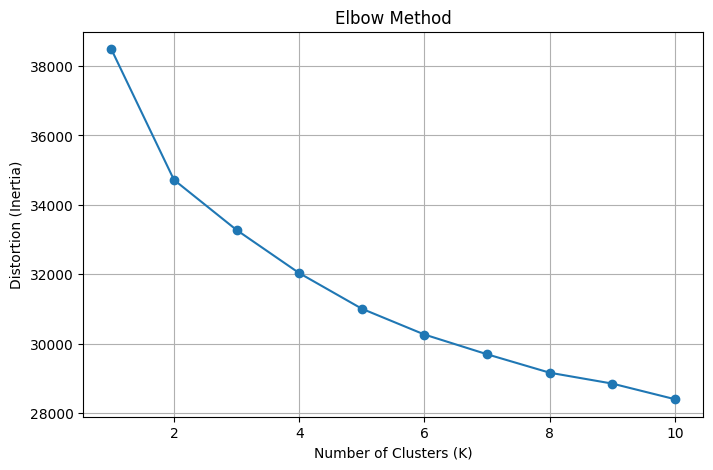

[38484.84647307503,
 34719.456669647894,
 33273.4787210732,
 32030.75909426862,
 31003.649478468193,
 30259.3727952266,
 29690.583280241433,
 29159.073521565195,
 28845.13632865795,
 28394.891948040924]

In [12]:
descubrirK(X_train_pca, k_max=10)

In [13]:
# 10. Model Training (K-Means Clustering)
K = 2

kmeans = KMeans(n_clusters=K, random_state=42, n_init=10)
kmeans.fit(X_train_pca)


,n_clusters,2
,init,'k-means++'
,n_init,10
,max_iter,300
,tol,0.0001
,verbose,0
,random_state,42
,copy_x,True
,algorithm,'lloyd'


<div id="centroide" style="color:#37475a; border-bottom: 7px solid orange; width: 100%; margin-bottom: 15px; padding-bottom: 2px"><h2>Determine the centroid</h2> </div>

In [14]:
# 11. Manual Cluster Assignment (Prediction Logic)
def asignar_clusters_manual(X_pca, centroides, K):
    clusters = []

    # Iterate through every instance (row) in the dataset
    for i in range(len(X_pca)):
        instancia = X_pca[i]

        # Initialize minimum distance to infinity so the first calculation always wins
        distancia_min = float('inf')
        cluster_mas_cercano = -1

        # Compare the current instance against every Centroid
        for c in range(K):
            centroide = centroides[c]

            # ---------------------------------------------------------
            # Calculate Euclidean Distance Manually
            # Formula: sqrt( sum( (point_coordinate - centroid_coordinate)^2 ) )
            # ---------------------------------------------------------
            suma = 0
            for j in range(len(instancia)):
                # Sum of squared differences for each dimension
                suma += (instancia[j] - centroide[j]) ** 2

            # Square root of the sum
            distancia = suma ** 0.5

            # If this centroid is closer than the previous best, update the assignment
            if distancia < distancia_min:
                distancia_min = distancia
                cluster_mas_cercano = c

        # Save the ID of the closest cluster found
        clusters.append(cluster_mas_cercano)

    return np.array(clusters)


In [15]:
# 12. Centroid Extraction and Prediction

# Retrieve the coordinates of the cluster centers (Centroids) found by the model.
# These centroids represent the "average" location of each group in the PCA space.
# Crucially, these are fixed based on the Training data.
centroides = kmeans.cluster_centers_

print(f"Centroids shape: {centroides.shape}")
print("Centroids coordinates loaded.")

# ---------------------------------------------------------
# Prediction on Training Set (Verification)
# ---------------------------------------------------------
# We apply our manual function to the training set.
# This serves as a sanity check to ensure our manual distance logic
# produces the same results as the library's internal logic.
train_clusters_manual = asignar_clusters_manual(
    X_train_pca, centroides, K
)

# ---------------------------------------------------------
# Prediction on Test Set (Inference)
# ---------------------------------------------------------
# This is the actual prediction phase required by the practice guide.
# We take the unseen Test data (X_test_pca) and map each instance
# to the nearest existing centroid.
test_clusters_manual = asignar_clusters_manual(
    X_test_pca, centroides, K
)

print("Manual cluster assignment completed for Train and Test sets.")


Centroids shape: (2, 17)
Centroids coordinates loaded.
Manual cluster assignment completed for Train and Test sets.




<div style="color:#37475a"><h2>Verification</h2> </div>

In [16]:
# 13. Verification of Manual Implementation

# Use the built-in Scikit-Learn .predict() method.
# This serves as the "Ground Truth" to validate our custom function.
train_clusters_kmeans = kmeans.predict(X_train_pca)
test_clusters_kmeans = kmeans.predict(X_test_pca)

# Compare the results of our manual function against the library's function.
# np.all() returns True only if every single element in both arrays is identical.

# Check Training set consistency
print("TRAIN results match:", np.all(train_clusters_manual == train_clusters_kmeans))

# Check Test set consistency
print("TEST results match:", np.all(test_clusters_manual == test_clusters_kmeans))

# If both print "True", it confirms that our logic for calculating
# Euclidean distance and assigning centroids is 100% correct.

TRAIN results match: True
TEST results match: True




<div style="color:#37475a"><h2>Most frequent value of the output variable of the instances</h2> </div>

In [17]:
# Initialize a dictionary to map Cluster ID -> Predicted Label (Diagnosis)
cluster_to_label = {}

# Iterate through each cluster formed (0 to K-1)
for cluster in range(K):

    # 1. Retrieve Training Instances belonging to the current Cluster
    # We look at the 'y_train' (Ground Truth) for all data points that were
    # assigned to this specific 'cluster' during the training phase.
    etiquetas_cluster = []

    for i in range(len(train_clusters_manual)):
        if train_clusters_manual[i] == cluster:
            # .iloc[i] is used because y_train is a Pandas Series
            etiquetas_cluster.append(y_train.iloc[i])

    # 2. Calculate the Most Frequent Value (Mode)
    # - np.unique: Finds unique classes (0 or 1) and counts them.
    # - return_counts=True: Returns the frequency of each class.
    valores, conteos = np.unique(etiquetas_cluster, return_counts=True)

    # Identify the label with the highest count (argmax)
    etiqueta_mas_frecuente = valores[np.argmax(conteos)]

    # 3. Store the Label Mapping
    # We assign the majority label to represent the entire cluster.
    # e.g., If Cluster 0 has 80% "Healthy" patients, Cluster 0 = "Healthy".
    cluster_to_label[cluster] = etiqueta_mas_frecuente

print("Cluster-to-Label mapping created:", cluster_to_label)

Cluster-to-Label mapping created: {0: np.int64(0), 1: np.int64(0)}


<div style="color:#37475a"><h2>K-Means Clustering Visualization</h2> </div>

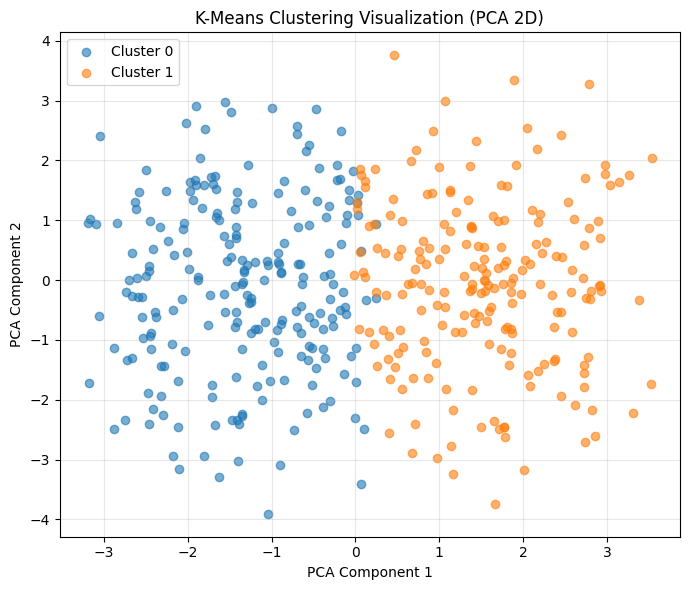

In [18]:
# Si ya tienes PCA con 2 componentes
X_2d = X_test_pca[:, :2]   # usar solo 2 dimensiones

plt.figure(figsize=(7, 6))

for cluster in range(K):
    points = X_2d[test_clusters_manual == cluster]
    plt.scatter(
        points[:, 0],
        points[:, 1],
        label=f"Cluster {cluster}",
        alpha=0.6
    )

plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("K-Means Clustering Visualization (PCA 2D)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

The figure shows a two-dimensional visualization of the dataset using Principal Component Analysis (PCA). Each point represents a patient, and colors indicate the clusters identified by the K-Means algorithm. Two main groups can be observed, which is consistent with the optimal value K = 2 obtained using the Elbow method. Although a partial separation between clusters is visible along the first principal component, there is still a noticeable overlap between them, which helps explain the limited predictive performance of the clustering approach.

<div id="pred" style="color:#37475a; border-bottom: 7px solid orange; width: 100%; margin-bottom: 15px; padding-bottom: 2px"><h2>Prediction</h2> </div>

In [19]:
# 15. Generating Final Predictions

# Initialize an empty list to store the final predicted labels (0 or 1).
y_pred = []

# Iterate through each instance in the Test set.
# 'test_clusters_manual' contains the Cluster ID (0 to K-1) for each person in the test set.
for i in range(len(test_clusters_manual)):

    # Get the cluster assigned to the current instance.
    cluster = test_clusters_manual[i]

    # Map the Cluster ID to the specific Class Label (Diagnosis)
    # using the 'cluster_to_label' dictionary created in the previous step.
    # Example: If Cluster 0 maps to "Healthy", and this person is in Cluster 0, prediction = "Healthy".
    y_pred.append(cluster_to_label[cluster])

# Convert the list to a NumPy array.
# This format is required by Scikit-Learn functions to calculate metrics
# like Accuracy, Precision, and Recall.
y_pred = np.array(y_pred)

print("Predictions generated. Ready for evaluation.")

Predictions generated. Ready for evaluation.


In [20]:
# 1. Explicitly calculate the Accuracy
accuracy = accuracy_score(y_test, y_pred)

# 2. Print full report
print("\n--- Classification Report (Clustering) ---")
print(classification_report(y_test, y_pred, zero_division=0))

# 3. Calculate individual metrics
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)

# 4. Print results
print(f"Accuracy:  {accuracy:.4f}")
print(f"F1-Score:  {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")



--- Classification Report (Clustering) ---
              precision    recall  f1-score   support

           0       0.65      1.00      0.79       278
           1       0.00      0.00      0.00       152

    accuracy                           0.65       430
   macro avg       0.32      0.50      0.39       430
weighted avg       0.42      0.65      0.51       430

Accuracy:  0.6465
F1-Score:  0.5077
Precision: 0.4180
Recall:    0.6465


<div id="comparacion" style="color:#37475a; border-bottom: 7px solid orange; width: 100%; margin-bottom: 15px; padding-bottom: 2px"><h2>Clustering (K-Means) vs Other Models</h2> </div>

In [21]:
data = [
    ["Logistic Regression", "Yes", 0.8093, 0.7940, 0.7824, 0.7874],
    ["Logistic Regression", "No",  0.8326, 0.8183, 0.8124, 0.8151],
    ["Decision Tree",       "Yes", 0.7767, 0.7558, 0.7543, 0.7550],
    ["Decision Tree",       "No",  0.9326, 0.9257, 0.9270, 0.9263],
    ["Random Forest",       "Yes", 0.8302, 0.8365, 0.7852, 0.8009],
    ["Random Forest",       "No",  0.9349, 0.9369, 0.9198, 0.9274],
    ["Gradient Boosting",   "Yes", 0.8395, 0.8389, 0.8028, 0.8156],
    ["Gradient Boosting",   "No",  0.9442, 0.9389, 0.9389, 0.9389],
    ["XGBoost",             "Yes", 0.8326, 0.8268, 0.7989, 0.8094],
    ["XGBoost",             "No",  0.9488, 0.9480, 0.9396, 0.9435],
    ["SVM",                 "Yes", 0.8140, 0.8000, 0.7860, 0.7919],
    ["SVM",                 "No",  0.8209, 0.8037, 0.8063, 0.8050],
    ["KNN",                 "Yes", 0.7372, 0.7198, 0.6775, 0.6865],
    ["KNN",                 "No",  0.7558, 0.7463, 0.6964, 0.7073],
    ["Neural Network",      "Yes", 0.7883, 0.7699, 0.7602, 0.7644],
    ["Neural Network",      "No",  0.8488, 0.7843, 0.7894, 0.7868],
    ["Naive Bayes",         "Yes", 0.8255, 0.8233, 0.7860, 0.7987],
]

columns = ["Model", "PCA", "Accuracy", "Precision", "Recall", "F1-Score"]
df_models = pd.DataFrame(data, columns=columns)

df_clustering = pd.DataFrame([[
    "Clustering (K-Means)", 
    "Yes",   # o "No" si no usaste PCA
    accuracy,
    precision,
    recall,
    f1
]], columns=columns)

df_comparison = pd.concat([df_models, df_clustering], ignore_index=True)
df_comparison

,Model,PCA,Accuracy,Precision,Recall,F1-Score
0,Logistic Regression,Yes,0.809300,0.794000,0.782400,0.787400
1,Logistic Regression,No,0.832600,0.818300,0.812400,0.815100
2,Decision Tree,Yes,0.776700,0.755800,0.754300,0.755000
3,Decision Tree,No,0.932600,0.925700,0.927000,0.926300
4,Random Forest,Yes,0.830200,0.836500,0.785200,0.800900
5,Random Forest,No,0.934900,0.936900,0.919800,0.927400
6,Gradient Boosting,Yes,0.839500,0.838900,0.802800,0.815600
7,Gradient Boosting,No,0.944200,0.938900,0.938900,0.938900
8,XGBoost,Yes,0.832600,0.826800,0.798900,0.809400
9,XGBoost,No,0.948800,0.948000,0.939600,0.943500


<div style="color:#37475a"><h2>
Graph</h2> </div>

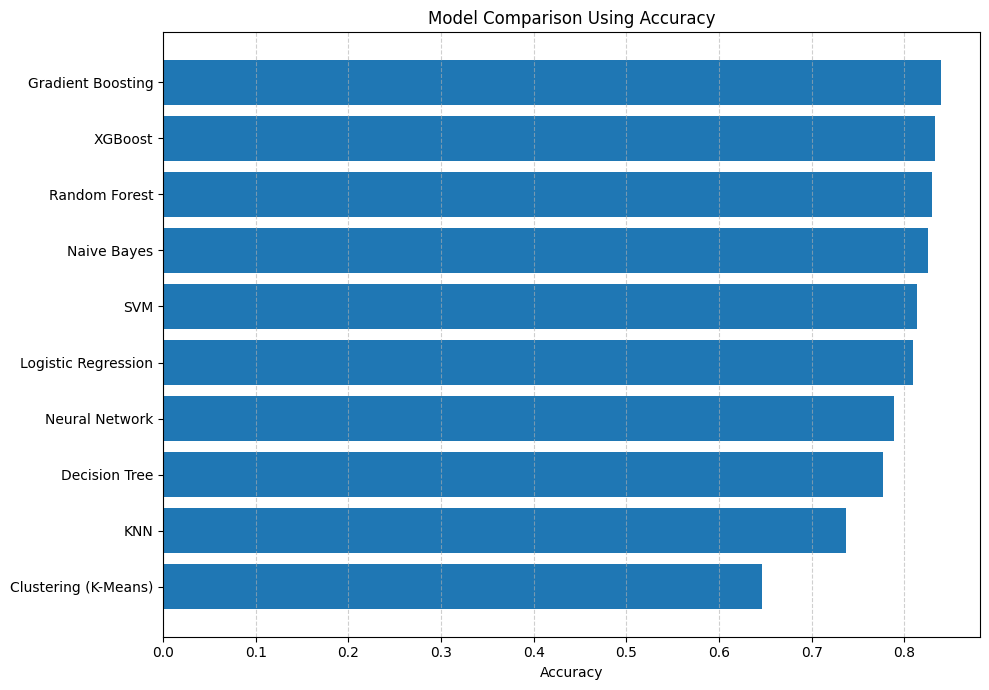

In [22]:
df_acc = (
    df_comparison
    .sort_values(by=["Model", "PCA"])   # asegura orden
    .drop_duplicates(subset="Model", keep="last")
)

# Ordenar por Accuracy
df_acc = df_acc.sort_values("Accuracy")

plt.figure(figsize=(10, 7))
plt.barh(df_acc["Model"], df_acc["Accuracy"])
plt.xlabel("Accuracy")
plt.title("Model Comparison Using Accuracy")
plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

The results show that supervised models clearly outperform the clustering-based approach in predicting Alzheimer’s disease. In particular, ensemble methods such as XGBoost and Gradient Boosting achieve the highest Accuracy values, demonstrating their ability to model complex relationships among clinical and demographic variables.

The clustering approach using K-Means, although exhibiting lower performance, is useful from an exploratory perspective, as it allows the identification of latent patterns and underlying structures in the data without requiring labels. However, its limited precision and F1-score confirm that it is not suitable as a primary predictive model, but rather as a complementary tool for exploratory data analysis.

Overall, the results highlight the importance of supervised learning for clinical diagnostic tasks, while clustering adds value in the initial understanding of the dataset and in the generation of hypotheses.

<div id="conclusion" style="color:#37475a; border-bottom: 7px solid orange; width: 100%; margin-bottom: 15px; padding-bottom: 2px"><h2>Conclusion</h2> </div>
The results indicate that dimensionality reduction and clustering help simplify the dataset and reveal underlying patterns. Using PCA, 17 components were sufficient to explain 85% of the variance, and the Elbow method identified K = 2 as the optimal number of clusters. However, the clustering approach achieved an accuracy of approximately 64%, which is relatively low compared to supervised models.

These findings confirm that, while clustering is useful for exploratory analysis and understanding data structure, it is not suitable as a primary predictive method. In contrast, supervised learning models—especially ensemble methods—provide significantly better performance for Alzheimer’s disease prediction, making them more appropriate for clinical diagnostic tasks.